In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876099,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167625,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742668,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.400536,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.565201,132079200


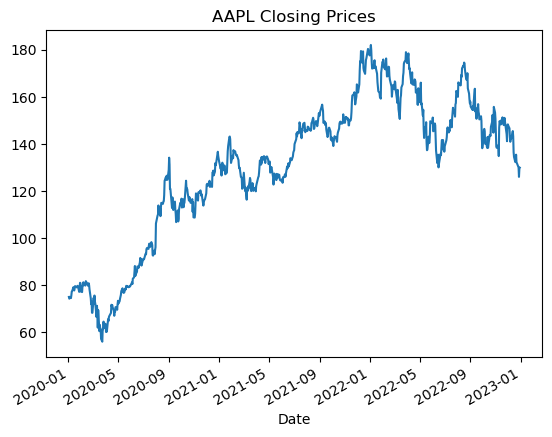

In [5]:
data['Close'].plot(title='AAPL Closing Prices')
plt.show()


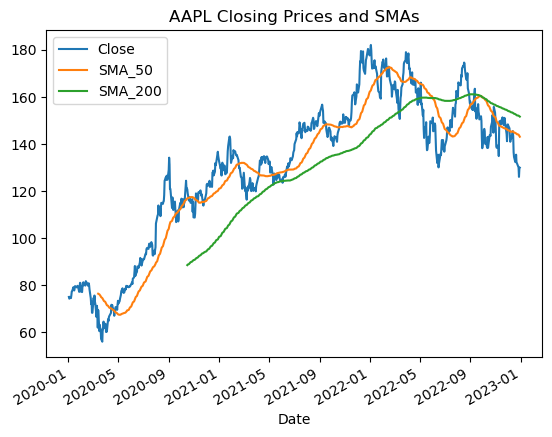

In [7]:
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data[['Close', 'SMA_50', 'SMA_200']].plot(title='AAPL Closing Prices and SMAs')
plt.show()


[*********************100%***********************]  1 of 1 completed


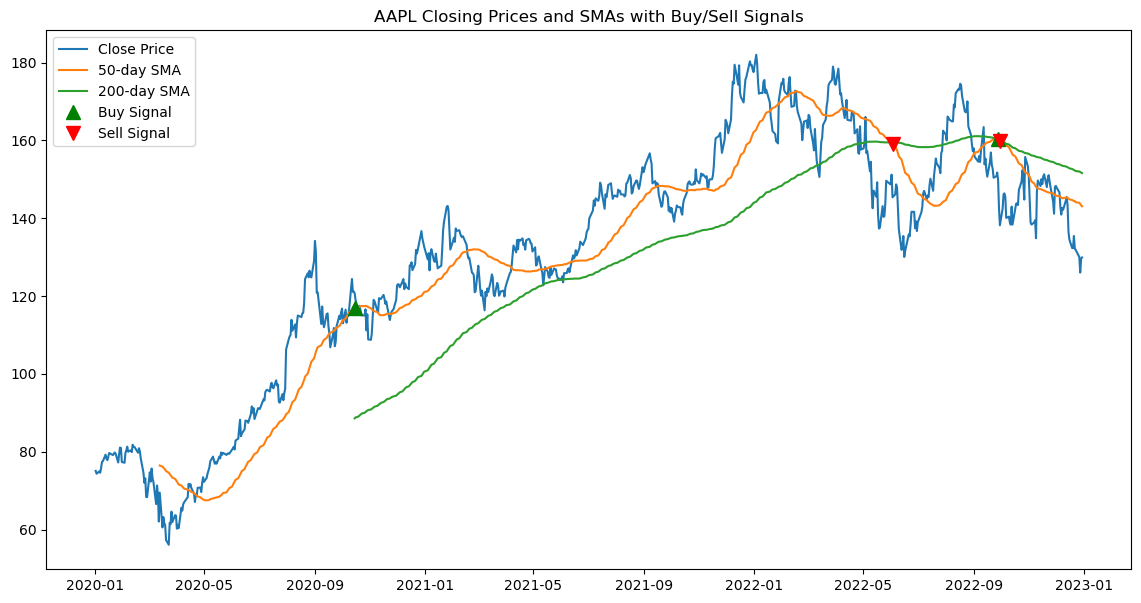

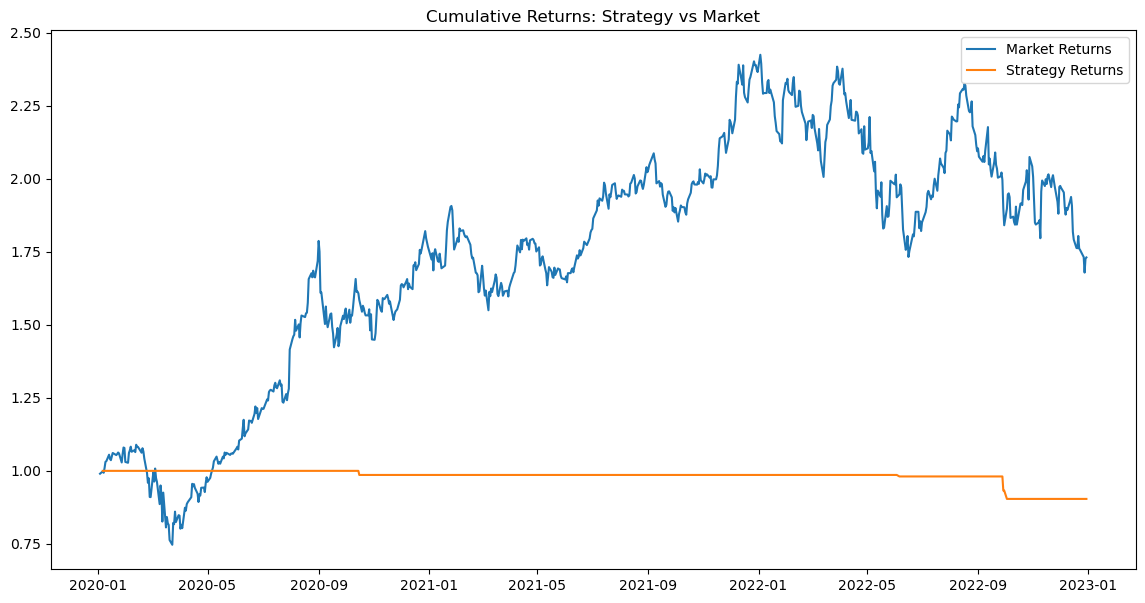

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch data
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')

# Ensure the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)

# Calculate moving averages
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

# Initialize the Signal column
data['Signal'] = 0

# Use .iloc for integer-based indexing
data.iloc[50:, data.columns.get_loc('Signal')] = np.where(data.iloc[50:, data.columns.get_loc('SMA_50')] > data.iloc[50:, data.columns.get_loc('SMA_200')], 1, 0)

# Create Position column
data['Position'] = data['Signal'].diff()

# Calculate returns
data['Market_Returns'] = data['Close'].pct_change()
data['Strategy_Returns'] = data['Market_Returns'] * data['Position'].shift(1)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_50'], label='50-day SMA')
plt.plot(data['SMA_200'], label='200-day SMA')
plt.plot(data.loc[data['Position'] == 1].index, 
         data['SMA_50'][data['Position'] == 1], 
         '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(data.loc[data['Position'] == -1].index, 
         data['SMA_50'][data['Position'] == -1], 
         'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('AAPL Closing Prices and SMAs with Buy/Sell Signals')
plt.legend()
plt.show()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot((1 + data['Market_Returns']).cumprod(), label='Market Returns')
plt.plot((1 + data['Strategy_Returns']).cumprod(), label='Strategy Returns')
plt.title('Cumulative Returns: Strategy vs Market')
plt.legend()
plt.show()


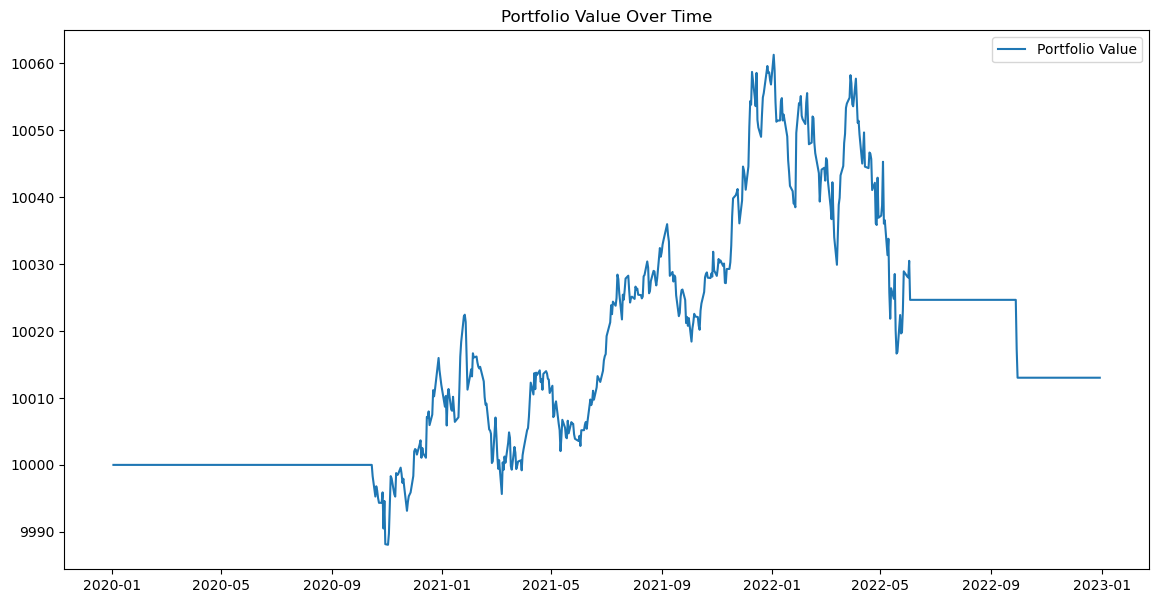

In [25]:
# Initial capital
initial_capital = 10000

# Create a DataFrame to store portfolio value
portfolio = pd.DataFrame(index=data.index)
portfolio['Holdings'] = data['Signal'] * data['Close']
portfolio['Cash'] = initial_capital - (data['Position'] * data['Close']).cumsum()
portfolio['Total'] = portfolio['Holdings'] + portfolio['Cash']

# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(portfolio['Total'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()




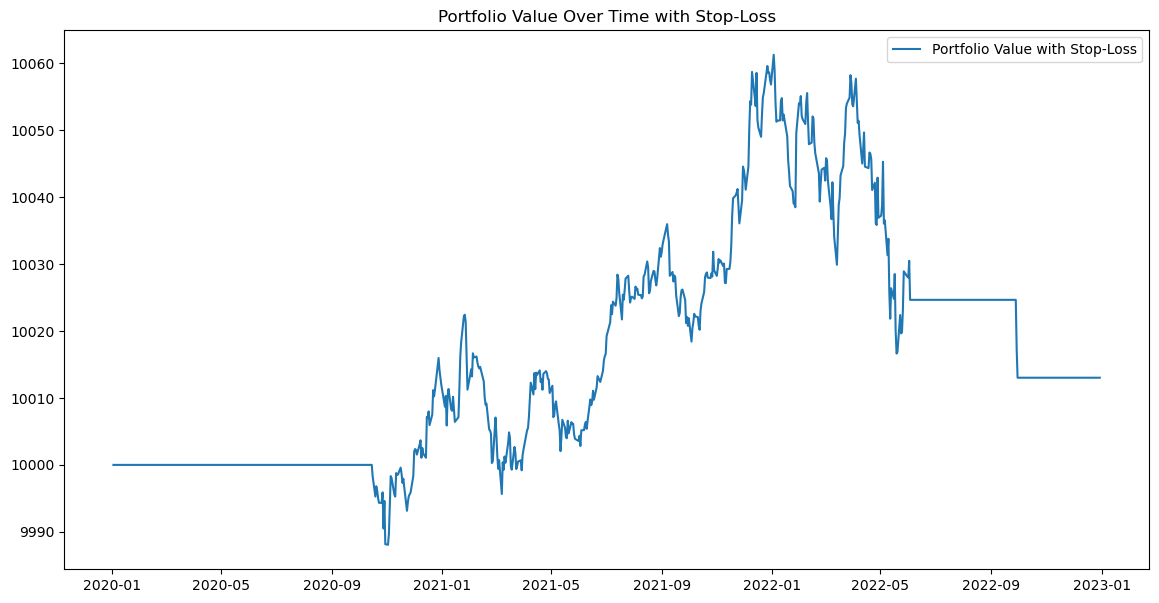

In [27]:
# Define stop-loss percentage
stop_loss_pct = 0.05

# Calculate stop-loss price
data['Stop_Loss'] = data['Close'] * (1 - stop_loss_pct)

# Implement stop-loss in the strategy
data['Signal'] = np.where((data['SMA_50'] > data['SMA_200']) & (data['Close'] > data['Stop_Loss']), 1, 0)
data['Position'] = data['Signal'].diff()

# Recalculate portfolio value with stop-loss
portfolio['Holdings'] = data['Signal'] * data['Close']
portfolio['Cash'] = initial_capital - (data['Position'] * data['Close']).cumsum()
portfolio['Total'] = portfolio['Holdings'] + portfolio['Cash']

# Plot the portfolio value over time with stop-loss
plt.figure(figsize=(14, 7))
plt.plot(portfolio['Total'], label='Portfolio Value with Stop-Loss')
plt.title('Portfolio Value Over Time with Stop-Loss')
plt.legend()
plt.show()
